In [43]:
!pip install mxnet-cu101mkl

In [0]:
import mxnet as mx
from mxnet import gluon, init

### Declare gluon sequential network

In [0]:
net = gluon.nn.Sequential()

### Add a hidden layer (256 nodes), output layer(10 nodes)

In [0]:
net.add(gluon.nn.Dense(256, activation = 'relu'), gluon.nn.Dense(10))

### Initialize with normal weights

In [0]:
net.initialize(init.Normal(sigma=0.01))


### Soft max cross entropy loss

In [0]:
loss = gluon.loss.SoftmaxCrossEntropyLoss()


### Function to load fashion MNSIT

In [0]:
def load_data_fashion_mnist(batch_size, resize=None):
    """Download the Fashion-MNIST dataset and then load into memory."""
    dataset = gluon.data.vision
    trans = [dataset.transforms.Resize(resize)] if resize else [] # resize in terms of pixel

    ### The ToTensor() class normalizes the grayscale values by dividing by 255
    trans.append(dataset.transforms.ToTensor())
    trans = dataset.transforms.Compose(trans )
    mnist_train = dataset.FashionMNIST(train=True).transform_first(trans) # train data
    mnist_test = dataset.FashionMNIST(train=False).transform_first(trans) # test data

    ### return a tuple (train, test) in the batch_size specified
    return (gluon.data.DataLoader(mnist_train, batch_size, shuffle=True,
                                  num_workers=4, ),
            gluon.data.DataLoader(mnist_test, batch_size, shuffle=False,
                                  num_workers= 4))

In [0]:

batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

### Function to calculate sum of metrics

In [0]:
class Accumulator():

  def __init__(self, size):

    self.n = size

    self.data = [0] * self.n

  def add(self, data):

    self.data = [x + y for x,y in zip(data, self.data)]

  def __getitem__(self, i):

    if type(self.data[i]) == int:
      return self.data[i]

    return self.data[i].astype(float)[0]

### Animator class to visualize epochs dynamically

In [0]:
from IPython import display
import seaborn as sns
import matplotlib.pyplot as plt

class Animator:

  def __init__(self , x, y, title, labels, range, figsize, xlabel, ylabel ):

    self.x = x
    self.y = y
    self.title = title
    self.labels = labels
    self.xlabel = xlabel
    self.ylabel = ylabel
    self.range = range
    self.figsize = figsize



  def add_to_plot(self, x, y):

    """
    x : list of data points you want to add to x axis dimension : n
    y: list of lists where each list has a dimension n (n is the number of individual line plots)
    """
    # print("Hi")
    self.x = self.x + x
    for i, yi in enumerate(self.y):
      yi[:] = yi + y[i]
    

  

    sns.set_style("darkgrid")

    for i,j in enumerate(self.y):
      print(j)
      plt.legend().remove()
      plt.plot(self.x,j, label = self.labels[i])
    plt.legend()
    plt.title(self.title)
    plt.xlabel(self.xlabel)
    plt.ylabel(self.ylabel)
    plt.show()
    
    
    display.display(plt)
    display.clear_output(wait=True)
    

    
    
    
    



  




In [0]:
def train_epoch(net, train_iter, loss, updater):

  metric = Accumulator(3)
  if isinstance(updater, gluon.Trainer):
      updater = updater.step


  for X,y in train_iter:

    with mx.autograd.record():
          y_hat = net(X)
          l = loss(y_hat , y)

    l.backward()

    updater(X.shape[0])

    metric.add([l.sum().astype(float), accuracy(y_hat, y).astype(float), y.size] )
  # print("hi")
  # print(metric.data)

  return metric[0]/metric[2] , metric[1] / metric[2]

In [0]:
def accuracy(y_hat, y):
    if y_hat.shape[1] > 1:
        return ((y_hat.argmax(axis=1) == y.astype('float32')).sum()).astype('float32')
    else:
        return ((y_hat.astype('int32') == y.astype('int32')).sum()).astype('float32')

In [0]:
def eval_accuracy(net, data_iter):

  metric = Accumulator(2)

  for X,y in data_iter:
     metric.add([accuracy(net(X), y), y.size])

  return metric[0] / metric[1]

In [0]:
def trainch3( net, train_iter,test_iter, loss, epochs, updater):

  animator = Animator([],[[],[],[]], "Performance metrics", ["train loss", "train accuracy", "test accuracy"], (3,4), (3,4), "epoch", "value")


  for epoch in range(epochs):
    train_metrics = train_epoch(net, train_iter, loss, updater)
    test_acc = eval_accuracy(net, test_iter)
    #animator_trainloss.add_plot(epoch+1, train_metrics[0] )
    #animator_trainaccuracy.add_plot(epoch+1, train_metrics[1])
    y_pt = [list(train_metrics[0].asnumpy()), list(train_metrics[1].asnumpy()), list(test_acc.asnumpy())]
    animator.add_to_plot([epoch+1], y_pt)

In [0]:

batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

No handles with labels found to put in legend.


[0.7958412047704061, 0.4803445772488912, 0.42428669459025065, 0.39483096408843993, 0.3674234453201294, 0.3526188730239868, 0.33573605273564655, 0.3258668579419454, 0.3146165096918742, 0.30239636567433675]
[0.7040166666666666, 0.82325, 0.84375, 0.85355, 0.8641166666666666, 0.8681666666666666, 0.8761166666666667, 0.8788833333333333, 0.88285, 0.8885]
[0.8237, 0.8356, 0.8416, 0.8122, 0.8532, 0.8062, 0.8744, 0.8508, 0.8145, 0.8446]


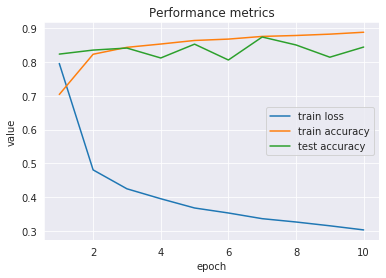

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

In [58]:

batch_size, num_epochs = 256, 10
train_iter, test_iter = load_data_fashion_mnist(batch_size)
loss = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.5})
trainch3(net, train_iter, test_iter, loss, num_epochs, trainer)
